# Data Description and Project Goals

## Abstract

This project uses a Covid-19 dataset that contains over 1 million unique patients and 21 columns. Some of the main features of this
dataset set consist of patient type, age, pneumonia, COPD, diabetes, and more. First, we verified whether the data was clean and
generated charts to view the distribution of each of the features in the dataset to look for imbalances. We did have to generate a
new column to provide a binary classification for whether a patient had died from Covid-19. The main goal of this project was to train a supervised machine learning model and determine whether a patient is at risk given their current symptom, status, and medical history.

# Data Preparation and Feature Engineering

## Creating Spark Session

In [7]:
# Create PySpark session

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Covid19").getOrCreate()

## Loading the Dataset

In [8]:
# Load the CSV dataset
df = spark.read.csv("covid_data.csv", header=True, inferSchema=True)

# Show the first 5 rows
df.show(5)

# Print the schema
df.printSchema()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

In [23]:
# Create temp view
df.createOrReplaceTempView("covid")

## Feature Engineering

In [9]:
# Create a column 'hasDied' that is set to 1 if the patient has died, 0 otherwise
from pyspark.sql.functions import when

default_date = "9999-99-99"

df = df.withColumn("hasDied", when(df["DATE_DIED"] == default_date, 0).otherwise(1))

df.show(5)

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|hasDied|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|      1|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|         

In [10]:
# Drop the 'DATE_DIED' column
df = df.drop("DATE_DIED")

## Data Exploration

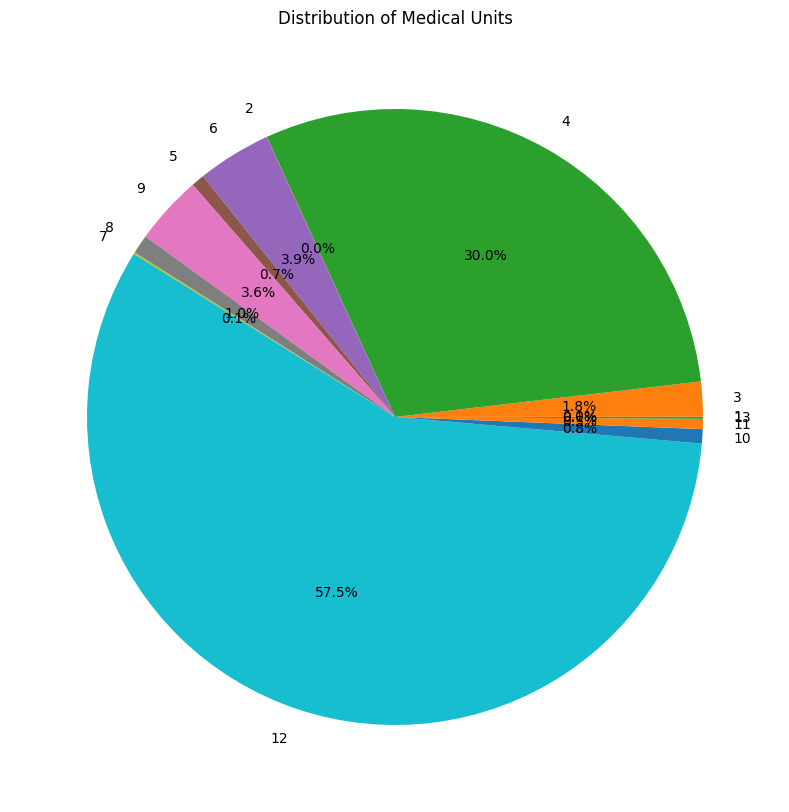

In [ ]:
# Show distribute of MEDICAL_UNIT column in pie chart
import matplotlib.pyplot as plt

medical_units_distribution = spark.sql("SELECT MEDICAL_UNIT, COUNT(*) AS count FROM covid GROUP BY MEDICAL_UNIT").toPandas()

plt.figure(figsize=(15, 10))
plt.pie(medical_units_distribution["count"], labels=medical_units_distribution["MEDICAL_UNIT"], autopct="%1.1f%%")

plt.title("Distribution of Medical Units")
plt.show()

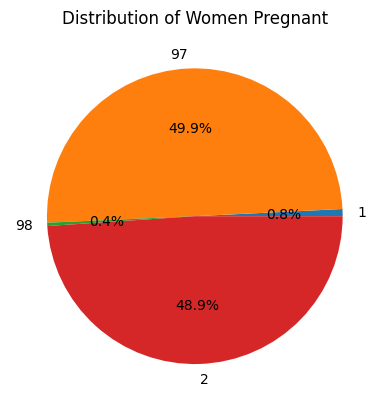

In [43]:
# Show distribution of 'PREGNANT' column in pie chart
import matplotlib.pyplot as plt

pregnant_distribution = spark.sql("SELECT PREGNANT, COUNT(*) as Count FROM covid GROUP BY PREGNANT").toPandas()

plt.pie(pregnant_distribution["Count"], labels=pregnant_distribution["PREGNANT"], autopct="%1.1f%%")
plt.title("Distribution of Women Pregnant")
plt.show()

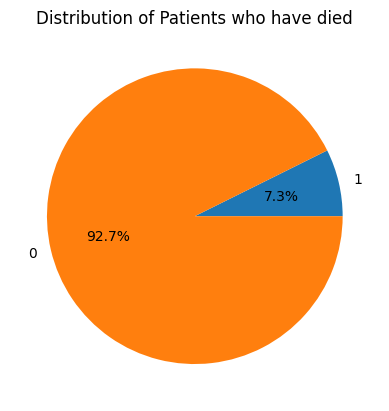

In [51]:
# Show distribution of 'hasDied' column in pie chart
import matplotlib.pyplot as plt

died_distribution = spark.sql("SELECT hasDied, COUNT(*) as Count FROM covid GROUP BY hasDied").toPandas()

plt.pie(died_distribution["Count"], labels=died_distribution["hasDied"], autopct="%1.1f%%")
plt.title("Distribution of Patients who have died")
plt.show()

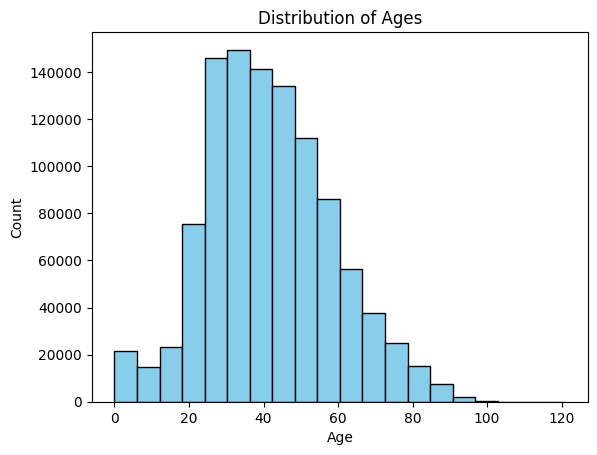

In [52]:
# Show distribution of 'AGE' column in histogram
import matplotlib.pyplot as plt

age_distribution = spark.sql("SELECT AGE FROM covid").toPandas()

plt.hist(age_distribution["AGE"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

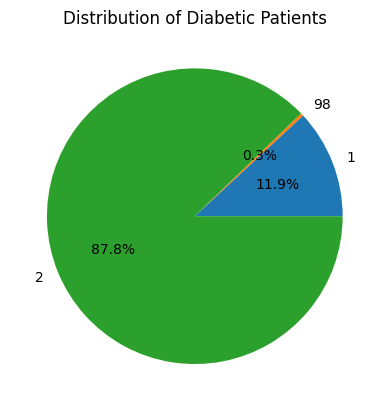

In [53]:
# Show distribution of 'DIABETES' column in pie chart
import matplotlib.pyplot as plt

diabetes_distribution = spark.sql("SELECT DIABETES, COUNT(*) as Count FROM covid GROUP BY DIABETES").toPandas()

plt.pie(diabetes_distribution["Count"], labels=diabetes_distribution["DIABETES"], autopct="%1.1f%%")
plt.title("Distribution of Diabetic Patients")
plt.show()

# Machine Learning Algorithm Preparation and Tuning

# Model Evaluation and Visualization

# Limitations, Future Work, and Conclusion